In [1]:
import matplotlib.pyplot as plt
import numpy as np
import bitstring

## 引言 : 浮點數奇怪的精度
> [浮點數練習網站](https://float.exposed/0x7effffff)
* 0.1 + 0.7 != 0.8
* 0.1 + 0.2 != 0.3

In [2]:
print( f"0.1 + 0.7 = {0.1 + 0.7}")
print( f"0.1 + 0.2 = {0.1 + 0.2}")

0.1 + 0.7 = 0.7999999999999999
0.1 + 0.2 = 0.30000000000000004


# Chapter 1 : IEEE 754 32bits format
```
[ sign (1 bit) ][ exponent (8 bits) ] [ fraction ( 23 bits ) ]
exponent have bias +127
Ex: 2^4  ---> exponent = binary(127+4)
```
以 `0.1` 為例 <br>
$0.1_{10}$ <br> 
= $ 0.00010011001100110011001101_{2} $  
= $ 1.0011001100110011001101 * 2^{-4}$ <br>
= ( bit pattern ) 0 01111011 10011001100110011001101 <br>
= 0  (-4 + 127) ( 1.600000023841858 )
       
$1.600000023841858 = 1 + 10011001100110011001101 (0.600000023841858)$

不用存最前面的 1 可以再多存一位精確度 <br>
實際上存的是 $ 0.100000001490116119384765625$ 而非精確的 0.1

In [3]:
# 0.1 Floating points
f1 = bitstring.BitArray(float=1.0, length=32)

sign = f1.bin[0]   # 1 bit
exp  = f1.bin[1:9] # 8 bits
frac = f1.bin[9:]  # 23 bits

print(sign, exp, frac)
print(f"exp: {exp}, cuz +127 bias, Why >1 need to add bias? ")

0 01111111 00000000000000000000000
exp: 01111111, cuz +127 bias, Why >1 need to add bias? 


In [4]:
# 計算 0.1 的二進位
frac = "10011001100110011001101"
value = 0
start = 1 # 從 1/2 ^ 1 開始
for bit in frac:
        value += int(bit) * 0.5 ** start
        start += 1
print( f"fraction :  { value + 1 }")
print( f"Value actually stored in float  :  { (value + 1) * 2 ** ( 123 - 127) }")

fraction :  1.600000023841858
Value actually stored in float  :  0.10000000149011612


Qusetion 1 : 為什麼要加 bias ? 
Answer : 

> [Wiki](https://zh.wikipedia.org/wiki/IEEE_754) <br>
>採用指數的實際值加上固定的偏移值的辦法表示浮點數的指數，好處是可以用長度為{\displaystyle e}e個位元的無符號整數來表示所有的指數取值，這使得兩個浮點數的指數大小的比較更為容易，實際上可以按照字典次序比較兩個浮點表示的大小。

試想原本沒有加 127, 如果指數有正有負，如果當成 unsigned int 來比較指數位 8 bits, 負的首位元是 1 一定比正的大，我們想要floating points 比較時直接當作 unsigned int 比較，因此原本 -126 ~ +127 (為什麼是 -126 稍後闡述 )，變成 1 (最小的正規數) ~ 254(最大的正規數)


問題 : 為何最小指數次方 -126 ? <br>
答案 : 因為全部指數 8 bits 都是 0， 代表非正規化數，所以 exponent 應從 00000001 開始，扣掉 127 = -126

# Chapter 2 浮點數轉換

In [5]:
def float_2_IEEE754(float_num):
        bit_pattern = bitstring.BitArray(float=float_num, length=32)
        sign = bit_pattern.bin[0]   # 1 bit
        exp  = bit_pattern.bin[1:9] # 8 bits
        frac = bit_pattern.bin[9:]  # 23 bits
        print(f"Float number: {float_num}  ", sign, exp, frac, 
              f"Actually stored Value = {bit_pattern.float}")

float_2_IEEE754(0.1)
float_2_IEEE754(0.2)
float_2_IEEE754(0.3)

Float number: 0.1   0 01111011 10011001100110011001101 Actually stored Value = 0.10000000149011612
Float number: 0.2   0 01111100 10011001100110011001101 Actually stored Value = 0.20000000298023224
Float number: 0.3   0 01111101 00110011001100110011010 Actually stored Value = 0.30000001192092896


In [6]:
def bit_2_float(bit_string):
        sign = bit_string[0]   # 1 bit
        exp  = bit_string[1:9] # 8 bits
        frac = bit_string[9:]  # 23 bits

        power = int(exp, 2) - 127
        value = 0
        start = 1 # 從 1/2 ^ 1 開始
        for bit in frac:
                value += int(bit) * 0.5 ** start
                start += 1
        
        return ( 1 + value) * 2 ** power

test_bitstr = "00111110100110011001100110011010" # 0.3
bit_2_float(test_bitstr)

0.30000001192092896

In [7]:
# +0, -0
float_2_IEEE754(+0.0)
float_2_IEEE754(-0.0)

Float number: 0.0   0 00000000 00000000000000000000000 Actually stored Value = 0.0
Float number: -0.0   1 00000000 00000000000000000000000 Actually stored Value = -0.0


In [8]:
float_2_IEEE754(+1.0) # 1.0 * 2 ** 0  (127 - 127)
float_2_IEEE754(-1.0) # -1.0 * 2 ** 0 (127 - 127)

Float number: 1.0   0 01111111 00000000000000000000000 Actually stored Value = 1.0
Float number: -1.0   1 01111111 00000000000000000000000 Actually stored Value = -1.0


In [9]:
# not a number (nan) : 指數全為 1 而 分數不等於 0
float_2_IEEE754(np.nan)
# nan != nan


# infinite (inf) : 指數全為 1 而 分數等於 0
float_2_IEEE754(np.inf)

Float number: nan   0 11111111 10000000000000000000000 Actually stored Value = nan
Float number: inf   0 11111111 00000000000000000000000 Actually stored Value = inf


# Chapter 3 : 浮點數的安全範圍

In [10]:
float_2_IEEE754(123456789)

Float number: 123456789   0 10011001 11010110111100110100011 Actually stored Value = 123456792.0


在指定 32 bits 浮點數為 123456789 時，可看到實際儲存不是123456789，而是123456792

In [11]:
# 123456789 --> 轉成 binary
test_str = bin(123456789)[2:] # remove 0b prefix
print(test_str, ", length is", len(test_str))

111010110111100110100010101 , length is 27


$111010110111100110100010101$ <br>
= $1.11010110111100110100010101 * 2^{26} $ <br>

因為後面有 26 bits，但是 32bits floating points 的 fraction 只有 23 bits，所以要 **向上捨入** 3 bits <br>
= $1.11010110111100110100011 (捨入進位) * 2^{26} $ <br>

接著，將此字串依照 IEEE 754 格式 <br>
exp  = 26 + 127 = 153 ( 10011001 ) <br>
frac = 7043491 ( 11010110111100110100010 ) <br>

123456789.0 = 0 10011001 11010110111100110100011 


In [12]:
bit_2_float("01001100111010110111100110100011")

123456792.0

可以看到，由於向上捨入 3 bits，造成一些精度被丟失，所以無法正確儲存 123456789 <br>
因此，我們可以知道，
### 浮點數其實是 **離散** 的，在一定範圍內是連續的，範圍外是離散的

Question : 範圍是 ? <br>
Ans : 只要能在 23 bits 內表示的話 ( fraction 23 bits )，那就不會被捨入而丟失精度，因此，單精度安全範圍內最大整數是後面 23 bits 全 1 ( 8388607 ), $ 1.11111111111111111111111*2^{23} = 16777215$

In [13]:
int('1' * 23, 2)

8388607

In [14]:
int('1' * 24, 2)

16777215

In [15]:
for i in range(10):
        value = 16777212 + i
        bit_pattern = bitstring.BitArray(float=value, length=32)
        store_value = bit_2_float(bit_pattern.bin)
        print(value, ":", store_value)

16777212 : 16777212.0
16777213 : 16777213.0
16777214 : 16777214.0
16777215 : 16777215.0
16777216 : 16777216.0
16777217 : 16777216.0
16777218 : 16777218.0
16777219 : 16777220.0
16777220 : 16777220.0
16777221 : 16777220.0


可以看到只要 > 16777215 後就開始不連續了，逐漸發散

 # Chapter  4 : 非正規浮點數
 > * 如果浮點數的指數部分的 **編碼值是0，分數部分非零**，那麼這個浮點數將被稱為非正規形式的浮點數
 > * 一般是某個數字相當接近零時才會使用非規約型式來表示。 
 > * IEEE 754標準規定：非正規形式的浮點數的指數偏移值比正規形式的浮點數的指數偏移值小1。
 > * 漸進式下溢位（gradual underflow）
 > * 用來解決填補絕對值意義下最小規格數與零的距離。（舉例說，正數下，最大的非規格數等於最小的規格數。而一個浮點數編碼中，如果exponent=0，且尾數部分不為零，那麼就按照非規約浮點數來解析）
 > * [Stack Overflows](https://stackoverflow.com/questions/46732247/ieee-754-32-bit-single-precision-exponent-126-instead-of-127)
 > * [IEEE 754 標準](http://ieee-754.blogspot.com/)

[揭密浮點數](https://zhuanlan.zhihu.com/p/89320102) 一文所述
定義非正規化浮點數的目的 : 是希望最小正規數和 0 之間 **更平滑**，因此可以儲存更多的很小的數

In [16]:
# 由上文可知，正規浮點數最小的值為 1.0 * 2^-126
# min normalize number
float_2_IEEE754(2**-126)

# max normalize number
max_normal_float = bit_2_float("01111111011111111111111111111111")
float_2_IEEE754(max_normal_float)

Float number: 1.1754943508222875e-38   0 00000001 00000000000000000000000 Actually stored Value = 1.1754943508222875e-38
Float number: 3.4028234663852886e+38   0 11111110 11111111111111111111111 Actually stored Value = 3.4028234663852886e+38


小於 1.1754943508222875e-3 underflow, 大於 3.4028234663852886e+38 為 overflow

[IEEE 754 single-precision](https://www.quora.com/Why-is-2-149-the-smallest-normalized-gap-in-the-IEEE-754-single-precision-format)

* 最小的正號正規浮點數 : E = 1, M = 0 ---> 2 ^ -126
* 次小的正號正規浮點數 : E = 1, M = 1 ---> 2 ^ -126 * ( 1 + 2 ^ -23 ) 大約等於 2 ^ -126 + 2 ^ -149
  和原本相差 2^ -149

```
   0                          2 ^ -126         2 ^ -126 + 2 ^ -149
   |------------------------------|---------------------|-------
   a           2^-126             b       2^-149        c
    
    ab
   ----- = 2 ^ -23  --> 非常急促的降到 0 ， 有沒有更優雅的作法 ? <Ans> 漸進式下溢位
    bc

```

最小非正規化 : 0 00000000 00000000000000000000001 ( 2^-149 )
最大非正規化 : 0 00000000 11111111111111111111111 ( (1 - 2^-23) * 2 ^-126 )

```
    最小正規化   :  1.0000 0000 0000 0000 0000 000 (1      )  * 2 ^ -126
-)  最大非正規化 :  0.0000 0000 0000 0000 0000 001 (2 ^ -23)  * 2 ^ -126
---------------------------------------------------------------------------------
    最大非正規化 :  0.1111 1111 1111 1111 1111 111 (1-2^-23)  * 2 ^ -126

(1 - 2 ^-23 ) * 2^ -126 = 2^-126 - 2^-149 因此最小正規化數跟前後距離變得一樣了   2^-149 ~~ ( 漸進式下降 )

而 0 和 最小非正規化浮點數 2 ^-149 也一樣差了 2 ^ -149
```

**有了非正規化浮點數 再也不會驟降至0了。又可以儲存更多更小的小數**

 # Chapter 5 : 浮點數的密度與分布

![img](https://pic2.zhimg.com/80/v2-75cebc365c88cd9b8862e04ad3c52601_720w.png)
![img](https://pic2.zhimg.com/v2-96e6fafa938a2578e22496b8daf82691_r.jpg)

$F=(-1)^{S} * 2^{(E-127)}* (1 + \frac{M}{2^{23}})$

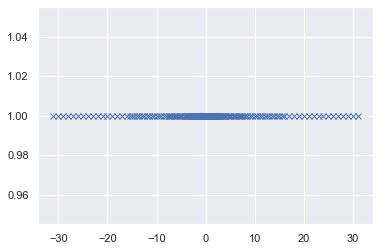

In [17]:
import seaborn as sns
significand_bits = 4

expon_max, expon_min = 4, -3
fp_numbers = []

for sign_bit in [1, 0]:
        for exp in range(expon_min, expon_max + 1):
                for bits in range(0, 2**significand_bits):
                        significand = (-1)**(sign_bit) * ( 1 + bits / 2**significand_bits ) * 2 ** exp
                        fp_numbers.append(significand)

fp_numbers = np.array(fp_numbers)

sns.set()
plt.plot(fp_numbers, np.ones_like(fp_numbers), "x")
plt.show()


![img](https://pic1.zhimg.com/v2-53e4a2b1c2d91a2581004f7511d78a50_r.jpg)